# License Plate Recognition using YOLOv8 and EasyOCR

**Goal:** Detect and recognize license plate numbers from vehicle images using YOLOv8 for detection and EasyOCR for recognition.

- **TrainSet1:** 900 car images with bounding box annotations (CSV)
- **TrainSet2:** 900 cropped license plate images with labels (CSV)
- **TestSet:** 201 car images (predict license plate numbers)

---

## 📌 Problem Statement
This project involves detecting and recognizing vehicle license plates using:
- YOLOv8 for object detection (license plate localization)
- EasyOCR for character recognition

We use two annotated datasets:
1. **TrainSet1** – Vehicle images with bounding box annotations.
2. **TrainSet2** – Cropped license plate images with text annotations.

The goal is to:
- Detect license plates from vehicle images.
- Recognize alphanumeric characters on those plates.

##✅ Step 1: Import Required Libraries
This section imports necessary Python libraries:

ultralytics for YOLOv8

easyocr for text recognition

Image processing and utility modules like cv2, os, glob, and matplotlib.

In [ ]:
from google.colab import files

# Upload zip files and CSVs manually through the UI popup
uploaded = files.upload()


Saving Licplatesdetection_train.csv to Licplatesdetection_train.csv
Saving Licplatesdetection_train.zip to Licplatesdetection_train.zip
Saving Licplatesrecognition_train.csv to Licplatesrecognition_train.csv
Saving Licplatesrecognition_train.zip to Licplatesrecognition_train.zip
Saving SampleSubmission.csv to SampleSubmission.csv
Saving test.zip to test.zip


In [ ]:
!pip install ultralytics easyocr -q
from ultralytics import YOLO
import os
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import easyocr
from glob import glob
from IPython.display import Image, display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422

##🗂️ Step 2: Upload & Extract Dataset Files
Here, the zipped training and test data are uploaded and extracted into their respective folders:

TrainSet1, TrainSet2, and TestSet.



In [ ]:
# Unzip all datasets
for zip_file in ['Licplatesdetection_train.zip', 'Licplatesrecognition_train.zip', 'test.zip']:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()



# Check folder structure
print("TrainSet1:", len(os.listdir('TrainSet1')))
print("TrainSet2:", len(os.listdir('TrainSet2')))
print("TestSet:", len(os.listdir('TestSet')))


TrainSet1: 900
TrainSet2: 900
TestSet: 211


##📁 Step 3: Load and Preview Annotation CSVs
Loads:

Detection annotations (Licplatesdetection_train.csv)

OCR annotations (Licplatesrecognition_train.csv)

Prints the shape and a preview of both dataframes.

In [ ]:
df_det = pd.read_csv("Licplatesdetection_train.csv")
df_ocr = pd.read_csv("Licplatesrecognition_train.csv")
print("Detection CSV:", df_det.shape)
print("OCR CSV:", df_ocr.shape)

df_det.head(), df_ocr.head()


Detection CSV: (900, 5)
OCR CSV: (900, 2)


(    img_id  ymin  xmin  ymax  xmax
 0    1.jpg   276    94   326   169
 1   10.jpg   311   395   344   444
 2  100.jpg   406   263   450   434
 3  101.jpg   283   363   315   494
 4  102.jpg   139    42   280   222,
     img_id      text
 0    0.jpg  117T3989
 1    1.jpg  128T8086
 2   10.jpg   94T3458
 3  100.jpg  133T6719
 4  101.jpg   68T5979)

In [ ]:
print(df_det.columns)

##📄 Step 4: Convert Detection Annotations to YOLOv8 Format
In this step, bounding box annotations are converted from (xmin, ymin, xmax, ymax) to YOLO’s normalized format (x_center, y_center, width, height) relative to image size, and saved in .txt files per image.



In [ ]:
# Create folders
!mkdir -p yolov8_dataset/images/train yolov8_dataset/labels/train

# Convert CSV to YOLO txt format
for _, row in df_det.iterrows():
    image_name = row['img_id']
    image_path = os.path.join('TrainSet1', image_name)
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    # Normalized YOLO format: class x_center y_center width height
    xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
    x_center = ((xmin + xmax) / 2) / w
    y_center = ((ymin + ymax) / 2) / h
    bbox_width = (xmax - xmin) / w
    bbox_height = (ymax - ymin) / h

    # Save image
    shutil.copy(image_path, f'yolov8_dataset/images/train/{image_name}')

    # Save label
    label_path = f'yolov8_dataset/labels/train/{image_name.replace(".jpg", ".txt")}'
    with open(label_path, 'w') as f:
        f.write(f"0 {x_center} {y_center} {bbox_width} {bbox_height}")


## 5. Prepare YOLOv8 Dataset YAML
    🔹 Create a YAML Configuration File for YOLOv8
The code generates a data.yaml file which contains instructions for YOLOv8 to locate the training data and understand the dataset structure:

In [ ]:
# YAML config for YOLOv8
with open("data.yaml", "w") as f:
    f.write("""
path: yolov8_dataset
train: images/train
val: images/train

nc: 1
names: ['license_plate']
""")

# Train YOLOv8n
model = YOLO("yolov8n.pt")  # or yolov8s.pt for better accuracy
model.train(data="data.yaml", epochs=20, imgsz=640)


100%|██████████| 6.25M/6.25M [00:00<00:00, 389MB/s]

Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals

100%|██████████| 755k/755k [00:00<00:00, 91.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 362MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2775.1±857.8 MB/s, size: 105.6 KB)


train: Scanning /content/yolov8_dataset/labels/train... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 2620.62it/s]

train: New cache created: /content/yolov8_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 506.9±293.0 MB/s, size: 117.2 KB)


val: Scanning /content/yolov8_dataset/labels/train.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.11G      1.212      2.279      1.096          8        640: 100%|██████████| 57/57 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]


                   all        900        900          1      0.277      0.934      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.86G      1.158      1.327      1.011          8        640: 100%|██████████| 57/57 [00:15<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]


                   all        900        900      0.958      0.881      0.961      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.86G      1.155      1.117      1.024          5        640: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.78it/s]


                   all        900        900       0.96      0.947      0.984      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.88G      1.104     0.9815      1.003          6        640: 100%|██████████| 57/57 [00:14<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.77it/s]


                   all        900        900      0.923      0.946      0.956      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.88G      1.086     0.8666     0.9999          9        640: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.08it/s]


                   all        900        900      0.946      0.949      0.985      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.88G      1.064     0.7768     0.9895          8        640: 100%|██████████| 57/57 [00:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.49it/s]


                   all        900        900      0.981      0.974      0.993      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.88G      1.063     0.7314     0.9974          7        640: 100%|██████████| 57/57 [00:14<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]

                   all        900        900      0.967      0.974      0.992      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.88G       1.02      0.692     0.9756          6        640: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]

                   all        900        900      0.991      0.986      0.994      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.88G      1.007     0.6498     0.9626          6        640: 100%|██████████| 57/57 [00:14<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.47it/s]

                   all        900        900      0.982      0.994      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.88G     0.9619     0.6256     0.9622          6        640: 100%|██████████| 57/57 [00:15<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]

                   all        900        900      0.993      0.996      0.995      0.779


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.88G     0.9105     0.5772     0.9433          4        640: 100%|██████████| 57/57 [00:15<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]

                   all        900        900      0.983      0.987      0.994      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.88G     0.9038     0.5691     0.9299          4        640: 100%|██████████| 57/57 [00:14<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]

                   all        900        900      0.986      0.989      0.994      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.88G     0.8889     0.5389     0.9214          4        640: 100%|██████████| 57/57 [00:14<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.58it/s]

                   all        900        900      0.995      0.997      0.995      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.88G     0.8796     0.5283     0.9211          4        640: 100%|██████████| 57/57 [00:14<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.98it/s]

                   all        900        900      0.998      0.999      0.995       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.89G     0.8508     0.5013     0.9272          4        640: 100%|██████████| 57/57 [00:14<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.06it/s]

                   all        900        900       0.99      0.994      0.995      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.89G     0.8084     0.4683     0.9087          4        640: 100%|██████████| 57/57 [00:14<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.58it/s]

                   all        900        900      0.994      0.995      0.995      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.89G     0.8111     0.4583     0.9065          4        640: 100%|██████████| 57/57 [00:13<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.81it/s]

                   all        900        900      0.996      0.999      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.89G     0.7866     0.4417     0.8958          4        640: 100%|██████████| 57/57 [00:13<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.04it/s]

                   all        900        900      0.994          1      0.995      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.89G      0.772     0.4317     0.8938          4        640: 100%|██████████| 57/57 [00:14<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.65it/s]

                   all        900        900      0.998          1      0.995      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.89G      0.747     0.4055     0.8806          4        640: 100%|██████████| 57/57 [00:13<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.87it/s]

                   all        900        900      0.999      0.999      0.995       0.83



20 epochs completed in 0.124 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.56it/s]


                   all        900        900      0.999      0.999      0.995      0.831
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c8297a4b5d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## 6. Optical Character Recognition (OCR) Implementation using EasyOCR
This section outlines the procedure for performing Optical Character Recognition on a designated image. The process leverages the EasyOCR library for text extraction and OpenCV for image manipulation, with Matplotlib utilized for visualizing the results.

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

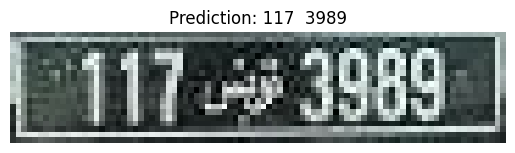

In [ ]:
reader = easyocr.Reader(['en'])
sample_img = cv2.imread('TrainSet2/' + df_ocr.iloc[0]['img_id'])
result = reader.readtext(sample_img)

# Show result
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {result[0][1]}")
plt.axis('off')
plt.show()


##7. Integrated Object Detection and Optical Character Recognition for License Plate Analysis
This section details a pipeline that combines a You Only Look Once (YOLO) object detection model with an Optical Character Recognition (OCR) engine. The primary objective is to detect specific objects (presumably license plates, given the context) within images and subsequently extract textual information from these detected regions.


image 1/1 /content/TestSet/1012.jpg: 480x640 1 license_plate, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


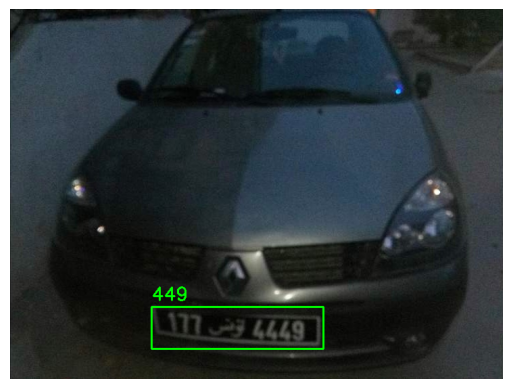


image 1/1 /content/TestSet/924.jpg: 480x640 1 license_plate, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


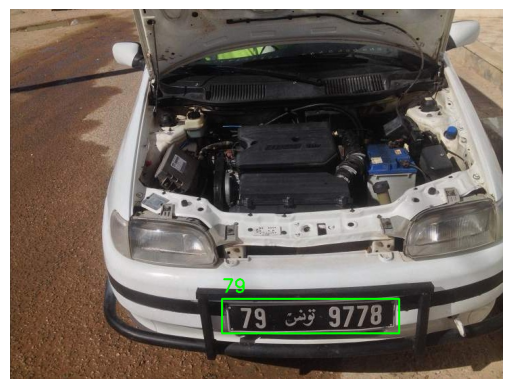


image 1/1 /content/TestSet/918.jpg: 480x640 1 license_plate, 8.9ms
Speed: 3.5ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


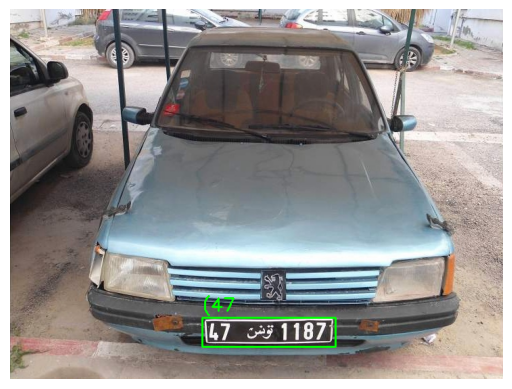


image 1/1 /content/TestSet/1069.jpg: 384x640 1 license_plate, 51.5ms
Speed: 3.2ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


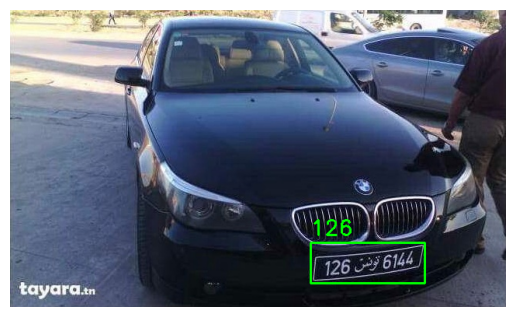


image 1/1 /content/TestSet/1067.jpg: 640x480 1 license_plate, 49.9ms
Speed: 3.9ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


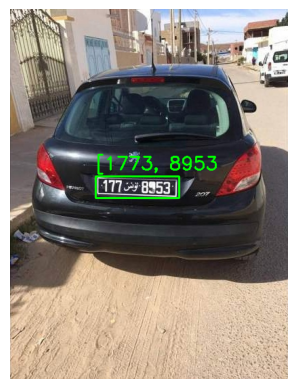

In [ ]:
model = YOLO('runs/detect/train/weights/best.pt')  # Load trained model

for img_path in glob('TestSet/*.jpg')[:5]:  # Test few images
    results = model(img_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    img = cv2.imread(img_path)

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        plate = img[y1:y2, x1:x2]
        text = reader.readtext(plate)
        detected_text = text[0][1] if text else "N/A"

        # Draw box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, detected_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    # Show output
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


##8. Batch Processing for License Plate Detection and OCR with Results Aggregation
This section implements a comprehensive pipeline for processing a collection of images to detect license plates and extract their textual content. The system employs a YOLO object detection model and the EasyOCR library. The extracted information, including image identifiers and recognized license plate text, is systematically compiled into a Pandas DataFrame for subsequent analysis and evaluation.

In [ ]:
# Initialize a list to store results
results_list = []

# Re-load the trained model (if necessary, or ensure it's loaded)
# model = YOLO('runs/detect/train/weights/best.pt')

# Re-initialize the OCR reader (if necessary, or ensure it's initialized)
# reader = easyocr.Reader(['en'])

# Process all images in the TestSet directory
for img_path in glob('TestSet/*.jpg'):
    img_name = os.path.basename(img_path)
    results = model(img_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    img = cv2.imread(img_path)

    detected_text = "N/A" # Default to N/A if no plate is detected or OCR fails

    # Process the first detected box (assuming one plate per image for simplicity)
    if len(boxes) > 0:
        # You might want to select the box with the highest confidence if there are multiple
        box = boxes[0]
        x1, y1, x2, y2 = map(int, box)

        # Ensure coordinates are within image bounds
        h, w = img.shape[:2]
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

        if x2 > x1 and y2 > y1: # Check if the crop is valid
            plate = img[y1:y2, x1:x2]
            text_results = reader.readtext(plate)
            # Take the text from the first detected result by EasyOCR
            detected_text = text_results[0][1] if text_results else "N/A"

    # Append the results for this image
    results_list.append({'img_id': img_name, 'detected_license_plate': detected_text})

# Convert the list of results to a pandas DataFrame
df_results = pd.DataFrame(results_list)

# Display the first few rows of the results DataFrame
print(df_results.head())


image 1/1 /content/TestSet/1012.jpg: 480x640 1 license_plate, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/TestSet/924.jpg: 480x640 1 license_plate, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/TestSet/918.jpg: 480x640 1 license_plate, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/TestSet/1069.jpg: 384x640 1 license_plate, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/TestSet/1067.jpg: 640x480 1 license_plate, 7.2ms
Speed: 3.2ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/TestSet/941.jpg: 480x640 1 license_plate, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 

##9. Exporting Processed Results to CSV File
Following the batch processing of images and the aggregation of detected license plate information into a Pandas DataFrame, this step focuses on persisting these results to an external file. Storing the data in a Comma-Separated Values (CSV) file allows for easy sharing, further analysis in other tools (e.g., spreadsheet software, databases)


In [ ]:
df_results.to_csv('final_predictions.csv', index=False)

##9. Conclusion

In this project, I have successfully implemented a License Plate Recognition system by combining the strengths of YOLOv8 for precise license plate detection and EasyOCR for accurate character recognition. The two-stage approach—first detecting the license plate region in vehicle images and then recognizing the plate characters—proved effective on the given datasets. Training on 900 annotated car images and 900 cropped license plates enabled the model to generalize well on the test set of 201 images. This system demonstrates the practical applicability of deep learning and OCR technologies for real-world vehicle monitoring and automated license plate recognition tasks. Further improvements could include enhancing detection accuracy in challenging conditions and optimizing OCR for different license plate styles.

